In [132]:
import fasttext
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
import re
from datetime import datetime, timedelta
import glob
import json
import tensorflow
import keras
import multiprocessing as mp
from joblib import Parallel, delayed
import os
from wordsegment import segment
from sklearn.metrics.pairwise import cosine_similarity
import ijson
from sklearn.metrics import f1_score
# http://thinknook.com/10-ways-to-improve-your-classification-algorithm-performance-2013-01-21/

In [3]:
def transform_text(df, retain_special_chars=False):
    body = df.bodyText\
    .str.replace("I'm ", "I am ")\
    .str.replace("It's ", 'It is ')\
    .str.replace("'ve ", " have ")\
    .str.replace("'re ", ' are ')\
    .str.replace("n't ", " not ")\
    .str.replace(" ([a-z]+)('s) ", ur' \1 is ')\
    .str.lower()

    if retain_special_chars:
        body = body\
        .str.replace('([a-zA-Z0-9]+)(\W)', ur'\1 \2')\
        .str.replace('(\W)([a-zA-Z0-9])', ur'\1 \2')
    else:
        body = body\
        .str.replace('\W', ' ')

    body = body\
    .str.replace('\s\s+', ' ')
    
    return body
    

def normalize_for_fasttext(df, topics, fname='fasttext_normalized_train_body_data.csv', retain_special_chars=False, with_labels=True):
    body = transform_text(df, retain_special_chars=retain_special_chars)
    labels = df.topics.map(topics.intersection)

    if with_labels:
        if not topics:
            raise ValueError('Topics must not be empty if with_labels is set to True!')
        
        labels = labels.map(
            lambda x: u' , '.join([u'__label__{}'.format(i) for i in x if i in topics]) if x else u'__label__null'
        )

        body = labels + ' , ' + body

    if fname:
        body.to_csv(fname, mode='a', index=False, encoding='utf-8')
        return labels.reset_index()
    else:
        return body

In [4]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = set(sample_sub.columns.difference(['id']))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
len(topics)

160

In [5]:
num_proc = mp.cpu_count() - 1

def parallel_corpus_processor(samp, normalize_for_fasttext, batch, num_proc, processing_kwargs):

    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0
        
        base_dir = './corpus'
        base_name = 'train_body_data-with_labels_{with_labels}-retain_special_chars_{retain_special_chars}'.format(**processing_kwargs)
        base_name = os.path.join(base_dir, base_name)

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(normalize_for_fasttext)(
                        t_df, fname=base_name + '_{}.csv'.format(j), **processing_kwargs
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)

In [76]:
# %%time
# train_df = pd.DataFrame()
# valid_labels_df = pd.DataFrame()
# batch = 5000
# store_fasttext = True
# compile_df = True


# processing_kwargs = dict(
#     with_labels=False,
#     retain_special_chars=False,
#     topics=topics
# )


# for fname in sorted(glob.glob('../data/TrainingData/*.json')):
#     print('Processing {}...'.format(fname))
#     with open(fname) as fl:
#         data = json.load(fl)
#         df = pd.DataFrame(data['TrainingData'])
#         df = df.T

#         if store_fasttext:
#             # for i in range(0, df.shape[0] + batch, batch):
#             #     ddf = df[i: i + batch]

#             #     if not ddf.empty:
#             #         normalize_for_fasttext(ddf, topics, fname='fasttext_normalized_train_body_data.csv', with_labels=True)
#             lf = parallel_corpus_processor(
#                 df, normalize_for_fasttext=normalize_for_fasttext,
#                 batch=batch, num_proc=num_proc, processing_kwargs=processing_kwargs,
#             )
            
#             if lf.empty:
#                 valid_labels_df = lf
#             else:
#                 valid_labels_df = valid_labels_df.append(lf)

#         if compile_df:
#             cols = ['topics', 'webPublicationDate']
#             if train_df.empty:
#                 train_df = df[cols]
#             else:
#                 train_df = train_df.append(df[cols])


# with open('../data/TestData.json') as fl:
#     data = json.load(fl)
#     test_df = pd.DataFrame(data['TestData']).T
#     if store_fasttext:
#         parallel_corpus_processor(
#             test_df, normalize_for_fasttext=normalize_for_fasttext,
#             batch=batch, num_proc=num_proc, processing_kwargs=processing_kwargs,
#         )

# if train_df.shape[0] == 1600462:
#     if (train_df.columns == [u'topics', u'webPublicationDate']).sum() == 2:
#         train_df.to_json('../data/training_id_topics.json')

Processing ../data/TrainingData/1999a_TrainingData.json...
Current batch in main thread: 30000
Processing ../data/TrainingData/1999b_TrainingData.json...
Current batch in main thread: 30000
Processing ../data/TrainingData/2000a_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/TrainingData/2000b_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/TrainingData/2001a_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/TrainingData/2001b_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/TrainingData/2002a_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/TrainingData/2002b_TrainingData.json...
Current batch in main thread: 30000
Current batch in main thread: 65000
Processing ../data/Train

In [6]:
train_df = pd.read_json('../data/training_id_topics.json')
valid_labels_df = train_df.topics.map(topics.intersection).reset_index()

In [7]:
train_topics = reduce(lambda x, y: x.union(y), valid_labels_df.topics)

In [100]:
%%time
data = []
index = []

for ix, row in enumerate(valid_labels_df[valid_labels_df.topics.map(len) != 0].iterrows()):
    _, row = row

    index.append(row['index'])
    data.append([1 if i in row.topics else np.nan for i in sorted(topics)])
    
    if ix % 1000 == 0: print ix
        
topic_train_index = pd.DataFrame(data, columns=sorted(topics), index=index)
topic_train_index.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [125]:
topic_train_index.columns[topic_train_index.sum() == 3]

Index([u'australianguncontrol'], dtype='object')

In [ ]:
from sklearn.decomposition import PCA

data = np.vstack(topic2vec_df.mean_topic_word_vec.values)
n_components = 10
n_delta = 10
topic_pca = PCA(n_components=n_components)
topic_pca.fit(data)

while topic_pca.explained_variance_ratio_.sum() < 0.90:
    n_components += n_delta
    topic_pca = PCA(n_components=n_components)
    topic_pca.fit(data)

In [133]:
def parse_training_data(path, keys=[], topics=[], limit=None):
    with open(path) as fl:
        parser = ijson.parse(fl)
        dataset = {}
        curr_index = None
        skip_index = None

        for prefix, event, value in parser:
            if 'map_key' == event and '_TrainingData_' in value:
                if limit:
                    if len(dataset) > limit:
                        break
            
            template = prefix.replace('TrainingData.', '').replace('.topics.item', '.topics')
            template = template.split('.')

            if event == 'string':
                for i in template:
                    if i == skip_index:
                        break

                    if '_TrainingData_' in i:
                        if keys and i not in keys:
                            skip_index = i
                            break

                        if curr_index != i:
                            if curr_index and dataset[curr_index].keys() == ['bodyText', 'webPublicationDate']:
                                dataset.pop(curr_index)

                            curr_index = i
                            dataset[curr_index] = {}
                        
                    elif 'bodyText' == i:
                        dataset[curr_index]['bodyText'] = value
                        
                    elif 'topics' == i:
                        if topics and value not in topics:
                            continue

                        dataset[curr_index][value] = 1
                    elif 'webPublicationDate' == i:
                        dataset[curr_index]['webPublicationDate'] = value

    return dataset

In [547]:
%%time

ds = parse_training_data('../data/TrainingData/2014b_TrainingData.json', topics=topics)
ds = pd.DataFrame(ds).T

for t in topics.difference(ds.columns):
    ds[t] = np.nan

CPU times: user 32.7 s, sys: 700 ms, total: 33.4 s
Wall time: 32.9 s


In [632]:
%%time

# processed_tname = {
#     '../data/TrainingData/2003b_TrainingData.json',
#     '../data/TrainingData/2004b_TrainingData.json',
#     '../data/TrainingData/2005a_TrainingData.json',
# }
# nan_rows = set()
# target_columns = sorted(topics)
# trainingX = pd.DataFrame()
# trainingY = pd.DataFrame()

for ix, tname in enumerate(glob.iglob('../data/TrainingData/*_TrainingData.json')):
    print('Processing {}. {}...'.format(ix + 1, tname))

    if ix <= 2 or tname in processed_tname:
        continue

    ds = parse_training_data(tname, topics=topics)
    ds = pd.DataFrame(ds).T

    for t in topics.difference(ds.columns):
        ds[t] = np.nan

    print('Done parsing {} docs with valid topics...'.format(ds.shape[0]))

    print('Computing features...')
    %time feature_vec = transform_text(ds.head(ts)).map(lambda x: np.array([fs_model[w] for w in x.split()]).mean(axis=0))

    nan_rows.update(feature_vec[feature_vec.isnull()].index.values)

    feature_vec = feature_vec[feature_vec.notnull()]

    if trainingX.empty:
        trainingX = feature_vec
    else:
        trainingX = trainingX.append(feature_vec)

    print('Current training size is {}...'.format(trainingX.shape[0]))

    targets = ds[target_columns].ix[feature_vec.index]  # .fillna(0).as_matrix()

    if trainingY.empty:
        trainingY = targets
    else:
        trainingY = trainingY.append(targets)

    trainingX.to_hdf('training_data_2', 'trainingX_fasttext')
    trainingY.to_hdf('training_data_2', 'trainingY_fasttext')
    
    print('Completed extracting data from {}...'.format(tname))
    print
    processed_tname.add(tname)

Processing 1. ../data/TrainingData/2003b_TrainingData.json...
Processing 2. ../data/TrainingData/2004b_TrainingData.json...
Processing 3. ../data/TrainingData/2005a_TrainingData.json...
Processing 4. ../data/TrainingData/1999b_TrainingData.json...
Processing 5. ../data/TrainingData/2003a_TrainingData.json...
Processing 6. ../data/TrainingData/2008b_TrainingData.json...
Done parsing 10799 docs with valid topics...
Computing features...


/home/avsolatorio/ml-ai/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


CPU times: user 9min 18s, sys: 4.31 s, total: 9min 23s
Wall time: 9min 16s
Current training size is 42039...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', u'alqaida', 'alshabaab', u'antiwar', u'armstrade', u'belgium', u'biometrics', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', u'dataprotection', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevaconventions', u'germany', u'guncrime', u'hacking', u'helicoptercrashes', u'humanitarianresponse', u'humanrights', u'humantrafficking', u'immigration', u'india', u'

Completed extracting data from ../data/TrainingData/2008b_TrainingData.json...

Processing 7. ../data/TrainingData/2009a_TrainingData.json...
Done parsing 10804 docs with valid topics...
Computing features...
CPU times: user 9min 45s, sys: 4.64 s, total: 9min 50s
Wall time: 9min 43s
Current training size is 52029...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', u'alqaida', 'alshabaab', u'antiwar', u'armstrade', u'belgium', u'biometrics', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', u'dataprotection', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevaconventions', u'germany', u'guncrime', u'hacking', u'helicoptercrashes', u'humanitarianresponse', u'humanrights', 'humanrightsact', u

Completed extracting data from ../data/TrainingData/2009a_TrainingData.json...

Processing 8. ../data/TrainingData/1999a_TrainingData.json...
Done parsing 970 docs with valid topics...
Computing features...
CPU times: user 1min 4s, sys: 540 ms, total: 1min 4s
Wall time: 1min 3s
Current training size is 52999...
Completed extracting data from ../data/TrainingData/1999a_TrainingData.json...

Processing 9. ../data/TrainingData/2002a_TrainingData.json...
Done parsing 5573 docs with valid topics...
Computing features...
CPU times: user 5min 34s, sys: 2.53 s, total: 5min 36s
Wall time: 5min 32s
Current training size is 58572...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', u'alqaida', 'alshabaab', u'antiwar', u'armstrade', u'belgium', u'biometrics', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', u'dataprotection', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevaconventions', u'germany', u'guncrime', u'hacking', u'helicoptercrashes', u'humanitarianresponse', u'humanrights', 'humanrightsact', u

Completed extracting data from ../data/TrainingData/2002a_TrainingData.json...

Processing 10. ../data/TrainingData/2012a_TrainingData.json...
Done parsing 9237 docs with valid topics...
Computing features...
CPU times: user 11min 16s, sys: 5.6 s, total: 11min 21s
Wall time: 11min 13s
Current training size is 67804...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', 'aid', u'alqaida', 'alshabaab', u'antiwar', 'arabandmiddleeastprotests', u'armstrade', u'belgium', 'bigdata', u'biometrics', 'bokoharam', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', u'dataprotection', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevaconventions', u'germany', u'guncrime',

Completed extracting data from ../data/TrainingData/2012a_TrainingData.json...

Processing 11. ../data/TrainingData/2004a_TrainingData.json...
Done parsing 7483 docs with valid topics...
Computing features...
CPU times: user 7min 53s, sys: 4.06 s, total: 7min 57s
Wall time: 7min 50s
Current training size is 75287...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', 'aid', u'alqaida', 'alshabaab', u'antiwar', 'arabandmiddleeastprotests', u'armstrade', u'belgium', 'bigdata', u'biometrics', 'bokoharam', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', 'darknet', u'dataprotection', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevaconventions', u'germany', u

Completed extracting data from ../data/TrainingData/2004a_TrainingData.json...

Processing 12. ../data/TrainingData/2014a_TrainingData.json...
Done parsing 9978 docs with valid topics...
Computing features...
CPU times: user 12min 17s, sys: 6.35 s, total: 12min 23s
Wall time: 12min 14s
Current training size is 85250...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', 'aid', u'alqaida', 'alshabaab', u'antiwar', 'arabandmiddleeastprotests', u'armstrade', u'belgium', 'bigdata', u'biometrics', 'bokoharam', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', 'darknet', u'dataprotection', 'debate', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', 'encryption', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicscience', u'france', u'freedomofspeech', u'genevacon

Completed extracting data from ../data/TrainingData/2014a_TrainingData.json...

Processing 13. ../data/TrainingData/2008a_TrainingData.json...
Done parsing 9033 docs with valid topics...
Computing features...
CPU times: user 8min 42s, sys: 4.57 s, total: 8min 46s
Wall time: 8min 40s
Current training size is 94281...
Completed extracting data from ../data/TrainingData/2008a_TrainingData.json...

Processing 14. ../data/TrainingData/2013a_TrainingData.json...
Done parsing 8956 docs with valid topics...
Computing features...
CPU times: user 10min 53s, sys: 5.85 s, total: 10min 59s
Wall time: 10min 51s
Current training size is 103234...


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', 'aid', 'algerianhostagecrisis', u'alqaida', 'alshabaab', u'antiwar', 'arabandmiddleeastprotests', u'armstrade', u'belgium', 'bigdata', u'biometrics', 'bokoharam', 'bostonmarathonbombing', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', 'darknet', u'dataprotection', 'debate', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', 'encryption', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'extradition', u'famine', u'farright', u'firefighters', u'forensicsc

Completed extracting data from ../data/TrainingData/2013a_TrainingData.json...

Processing 15. ../data/TrainingData/2000b_TrainingData.json...
Done parsing 2179 docs with valid topics...
Computing features...
CPU times: user 2min 5s, sys: 1.06 s, total: 2min 6s
Wall time: 2min 4s
Current training size is 105413...
Completed extracting data from ../data/TrainingData/2000b_TrainingData.json...

Processing 16. ../data/TrainingData/2001a_TrainingData.json...
Done parsing 2826 docs with valid topics...
Computing features...
CPU times: user 2min 55s, sys: 1.6 s, total: 2min 57s
Wall time: 2min 55s
Current training size is 108239...
Completed extracting data from ../data/TrainingData/2001a_TrainingData.json...

Processing 17. ../data/TrainingData/2005b_TrainingData.json...
Done parsing 6714 docs with valid topics...
Computing features...
CPU times: user 6min 7s, sys: 3.4 s, total: 6min 10s
Wall time: 6min 5s
Current training size is 114953...
Completed extracting data from ../data/TrainingDat

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block1_values] [items->[u'afghanistan', 'aid', 'algerianhostagecrisis', u'alqaida', 'alshabaab', u'antiwar', 'arabandmiddleeastprotests', u'armstrade', 'australianguncontrol', 'australiansecurityandcounterterrorism', u'belgium', 'bigdata', u'biometrics', 'bokoharam', 'bostonmarathonbombing', u'britisharmy', 'cameroon', 'carers', u'chemicalweapons', u'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', u'criminaljustice', u'cybercrime', 'cyberwar', 'darknet', u'dataprotection', 'debate', u'defence', 'deflation', 'drones', u'drugs', u'drugspolicy', u'drugstrade', u'earthquakes', u'ebola', u'economy', 'egypt', 'encryption', u'energy', u'espionage', u'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', u'ex

Completed extracting data from ../data/TrainingData/2014b_TrainingData.json...

Processing 24. ../data/TrainingData/2006b_TrainingData.json...
Done parsing 7426 docs with valid topics...
Computing features...
CPU times: user 7min 5s, sys: 4.03 s, total: 7min 9s
Wall time: 7min 4s
Current training size is 168932...
Completed extracting data from ../data/TrainingData/2006b_TrainingData.json...

Processing 25. ../data/TrainingData/2007b_TrainingData.json...
Done parsing 8011 docs with valid topics...
Computing features...
CPU times: user 7min 22s, sys: 4.08 s, total: 7min 26s
Wall time: 7min 21s
Current training size is 176943...
Completed extracting data from ../data/TrainingData/2007b_TrainingData.json...

Processing 26. ../data/TrainingData/2000a_TrainingData.json...
Done parsing 2044 docs with valid topics...
Computing features...
CPU times: user 1min 55s, sys: 988 ms, total: 1min 56s
Wall time: 1min 54s
Current training size is 178987...
Completed extracting data from ../data/Trainin

In [636]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [637]:
# %%time
# ts = 10000
# # feature_vec = transform_text(ds.head(100)).map(lambda x: fs_model[x])
# feature_vec = transform_text(ds.head(ts)).map(lambda x: np.array([fs_model[w] for w in x.split()]).mean(axis=0))

In [664]:
fv = trainingX[trainingX.notnull()]
sc.fit(np.vstack(fv))
fv.shape

(234083,)

In [669]:
train_index = sorted(fv.index)
np.random.shuffle(train_index)
train_index[:10]

[u'2004b_TrainingData_07009',
 u'2011b_TrainingData_39186',
 u'2003a_TrainingData_32386',
 u'1999a_TrainingData_17802',
 u'2003b_TrainingData_21454',
 u'2009a_TrainingData_23565',
 u'2007a_TrainingData_08685',
 u'2002b_TrainingData_34862',
 u'2003b_TrainingData_18985',
 u'2014a_TrainingData_00193']

In [529]:
(300 * 8) * 10000. * 33

792000000.0

In [189]:
# sims = cosine_similarity(
#     np.vstack(feature_vec), np.vstack(topic2vec_df.mean_topic_word_vec)
# )

# ix = 65
# print ds.iloc[ix][ds.iloc[ix].notnull()]
# for i in np.argsort(sims[ix])[::-1]:
#     print topic2vec_df.index[i], sims[ix][i]

In [834]:
kmodel = keras.models.Sequential()

kmodel.add(keras.layers.Dense(128, input_dim=300))
kmodel.add(keras.layers.Dropout(0.3))
kmodel.add(keras.layers.Activation('relu'))

kmodel.add(keras.layers.Dense(256))
kmodel.add(keras.layers.Dropout(0.3))
kmodel.add(keras.layers.Activation('relu'))

kmodel.add(keras.layers.Dense(128))
kmodel.add(keras.layers.Dropout(0.3))
kmodel.add(keras.layers.Activation('relu'))

kmodel.add(keras.layers.Dense(len(topics)))
kmodel.add(keras.layers.Activation('sigmoid'))

kmodel.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy'],
)
kmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 128)               38528     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
activation_107 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_108 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 128)               32896     
__________

In [960]:
%%time
kmodel.fit(
    sc.transform(np.vstack(fv.ix[train_index])),
    trainingY.ix[train_index].fillna(0).as_matrix(), batch_size=10000, epochs=10,
    validation_split=0.2,
)

Train on 187266 samples, validate on 46817 samples
Epoch 1/10
187266/187266 [==============================] - 2s - loss: 0.0143 - acc: 0.9954 - categorical_crossentropy: 2.0442 - val_loss: 0.0125 - val_acc: 0.9958 - val_categorical_crossentropy: 1.8389
Epoch 2/10
187266/187266 [==============================] - 2s - loss: 0.0142 - acc: 0.9954 - categorical_crossentropy: 2.0411 - val_loss: 0.0125 - val_acc: 0.9958 - val_categorical_crossentropy: 1.8360
Epoch 3/10
187266/187266 [==============================] - 2s - loss: 0.0142 - acc: 0.9954 - categorical_crossentropy: 2.0428 - val_loss: 0.0125 - val_acc: 0.9958 - val_categorical_crossentropy: 1.8370
Epoch 4/10
187266/187266 [==============================] - 2s - loss: 0.0142 - acc: 0.9954 - categorical_crossentropy: 2.0410 - val_loss: 0.0125 - val_acc: 0.9958 - val_categorical_crossentropy: 1.8338
Epoch 5/10
187266/187266 [==============================] - 2s - loss: 0.0142 - acc: 0.9954 - categorical_crossentropy: 2.0360 - val_loss

In [959]:
preds = kmodel.predict_proba(sc.transform(np.vstack(fv)))

234080/234083 [============================>.] - ETA: 0s

In [937]:
thresh = 0.01
preds[preds>=thresh] = 1
preds[preds<thresh] = 0

print f1_score(trainingY.ix[train_index].fillna(0).as_matrix(), preds, average='micro')

0.0072626743284


/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [961]:
bb = trainingY[trainingY.sum(axis=1) > 5].head(100)

In [962]:
pred = kmodel.predict_proba(sc.transform(np.vstack(fv.ix[bb.index])))

 32/100 [========>.....................] - ETA: 0s

In [963]:
pred.mean()

0.016841393

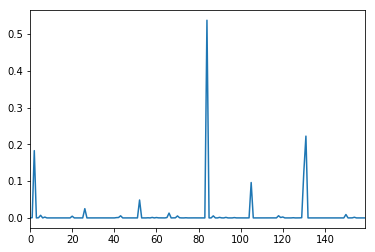

In [964]:
ix = 90
pd.Series(pred[ix]).plot()

In [965]:
print np.where(bb.iloc[ix] > 0)
print np.where(pred[ix] >  (pred[ix].mean() + 0.75 * pred[ix].std()))

(array([ 26,  84, 105, 130, 131, 154]),)
(array([  2,  52,  84, 105, 130, 131]),)


In [966]:
print np.where(bb.iloc[ix] > 0)
print np.where(pred[ix] >  pred[ix][np.where(pred[ix] > 0.001)].mean())  # (pred[ix].mean() + 0.75 * pred[ix].std()))

(array([ 26,  84, 105, 130, 131, 154]),)
(array([  2,  84, 105, 130, 131]),)


In [902]:
be = trainingY[trainingY.sum(axis=1) == 2].head(100)
epred = kmodel.predict_proba(sc.transform(np.vstack(fv.ix[be.index])))

 32/100 [========>.....................] - ETA: 0s

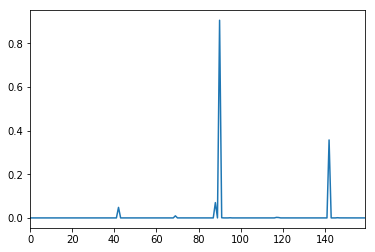

In [928]:
ix = 
pd.Series(epred[ix]).plot()

In [929]:
print np.where(be.iloc[ix] > 0)
print np.where(epred[ix] > (epred[ix].mean() + 1 * epred[ix].std()))

(array([42, 90]),)
(array([ 90, 142]),)


In [930]:
print np.where(be.iloc[ix] > 0)
print np.where(epred[ix] >  epred[ix][np.where(epred[ix] > 0.001)].mean())  # (pred[ix].mean() + 0.75 * pred[ix].std()))

(array([42, 90]),)
(array([ 90, 142]),)


In [939]:
epred[ix][(epred[ix] > 0.001)].mean()

0.19934334

In [ ]:
test_df.ix['TestData_07579'].bodyText

In [ ]:
test_sub_df.ix['TestData_07579'][test_sub_df.ix['TestData_07579'] == 1]

In [978]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05):
    return np.where(pred > max((pred.mean() + scale_param * pred.std()), min_thresh))[0]
#     return np.where(pred > max((pred[pred > 0.001].mean()), min_thresh))[0]

In [979]:
%%time
# valid_test_feature_vec found below!

test_values = np.zeros([valid_test_feature_vec.shape[0], len(topics)])
for ix, pred in enumerate(kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec)))):
    for v in get_classes(pred, scale_param=0.75):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=valid_test_feature_vec.index)
for i in test_feature_vec[test_feature_vec.isnull()].index:
    test_sub_df.ix[i] = np.zeros(len(topics))

7520/7578 [============================>.] - ETA: 0sCPU times: user 768 ms, sys: 52 ms, total: 820 ms
Wall time: 881 ms


In [980]:
test_sub_df.astype(int).reset_index().rename(columns={'index': 'id'}).sort_values('id').to_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv', index=False)

In [974]:
test_sub_df.sum(axis=1).sum()

36870.0

In [977]:
test_sub_df.sum(axis=1).sum()

34952.0

In [729]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')

In [732]:
top_submission.set_index('id').sum(axis=1)

id
TestData_00001    1
TestData_00002    5
TestData_00003    6
TestData_00004    0
TestData_00005    2
TestData_00006    4
TestData_00007    0
TestData_00008    0
TestData_00009    4
TestData_00010    3
TestData_00011    0
TestData_00012    0
TestData_00013    7
TestData_00014    0
TestData_00015    0
TestData_00016    1
TestData_00017    1
TestData_00018    5
TestData_00019    0
TestData_00020    0
TestData_00021    5
TestData_00022    2
TestData_00023    0
TestData_00024    1
TestData_00025    1
TestData_00026    2
TestData_00027    3
TestData_00028    4
TestData_00029    0
TestData_00030    1
                 ..
TestData_07552    2
TestData_07553    0
TestData_07554    3
TestData_07555    2
TestData_07556    5
TestData_07557    0
TestData_07558    1
TestData_07559    0
TestData_07560    2
TestData_07561    0
TestData_07562    0
TestData_07563    1
TestData_07564    1
TestData_07565    0
TestData_07566    0
TestData_07567    1
TestData_07568    0
TestData_07569    0
TestData_07570   

In [654]:
s = trainingY.head()[sorted(topics)]
s[s.notnull()]

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
2003b_TrainingData_00068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003b_TrainingData_00093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003b_TrainingData_00100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003b_TrainingData_00127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003b_TrainingData_00132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [657]:
np.where(s.values[0] == 1)

(array([76]),)

In [658]:
np.where(s.values == 1)

(array([0, 1, 2, 3, 4]), array([ 76,  76, 120,  76,  76]))

In [648]:
(kmodel.predict_proba(sc.transform(np.vstack(fv.head()))) > 0.00035).sum(axis=1)  #.argmax(axis=1)

5/5 [==============================] - 0s


array([20, 22,  4, 25, 15])

In [649]:
(kmodel.predict_proba(sc.transform(np.vstack(fv.head()))) > 0.002).argmax(axis=1)

5/5 [==============================] - 0s


array([  8,   6, 120,  66,   6])

In [660]:
p = (kmodel.predict_proba(sc.transform(np.vstack(fv.head()))) > 0.05)
np.where(p == 1)

5/5 [==============================] - 0s


(array([0, 0, 0, 1, 2, 3, 4]), array([ 34,  76,  98,  76, 120,  76,  76]))

In [520]:
p = (kmodel.predict_proba(sc.transform(np.vstack(fv.head()))) > 0.1)
np.where(p == 1)

5/5 [==============================] - 0s


(array([0, 1, 2, 2, 3, 3, 4, 4, 4, 4]),
 array([ 66,  41,  70, 131, 116, 125,  56,  60, 104, 125]))

In [623]:
pred = kmodel.predict_proba(sc.transform(np.vstack(fv.head(20000))))

19744/20000 [============================>.] - ETA: 0s

In [615]:
w = trainingY.sum(axis=1)
w[w > 4]
list(trainingY.index).index('2003b_TrainingData_06155')

1097

In [626]:
(pred.mean(axis=1) + pred.std(axis=1))

array([ 0.00528145,  0.00133199,  0.00523172, ...,  0.02053957,
        0.00371951,  0.02733777], dtype=float32)

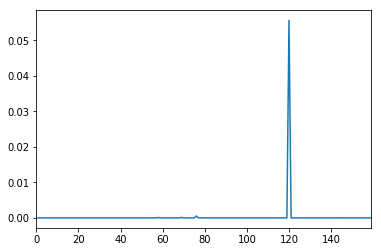

In [619]:
%matplotlib inline

d = pd.Series(pred[1097])
d.plot()

In [611]:
topic2vec_df.iloc[156]

mean_topic_word_vec    [0.0123051404953, 0.206452871983, -0.198155286...
topic_vec              [0.0357510633767, 0.139327511191, -0.103679254...
Name: womeninbusiness, dtype: object

In [12]:
fs_model = fasttext.load_model('./corpus/models/model_train_body_data-with_labels_False-retain_special_chars_False.bin')

In [177]:
topic2actual
topic2vec = {}

for topic, actual in topic2actual.items():
    topic_vec = np.array(fs_model[' '.join(actual)])
    mean_topic_word_vec = np.array([fs_model[w] for w in actual if w not in ['and', 'in', 'of']]).mean(axis=0)
    topic2vec[topic] = dict(
        topic_vec=topic_vec,
        mean_topic_word_vec=mean_topic_word_vec
    )

topic2vec_df = pd.DataFrame(topic2vec).T

In [84]:
term = 'carers'

In [85]:
sim = cosine_similarity(topic2vec_df.ix[term].topic_vec.reshape(1, -1), np.vstack(topic2vec_df.topic_vec.values))
for ix, i in enumerate(np.argsort(
    sim,
)[0][::-1]):
    print ix, topic2vec_df.index[i], sim[0][i]

0 carers 1.0
1 refugees 0.389063198824
2 localgovernment 0.37627013214
3 internallydisplacedpeople 0.375560678373
4 dataprotection 0.370663159257
5 retirementage 0.349338655313
6 womeninbusiness 0.343153673513
7 internetsafety 0.336918630343
8 humanrightsact 0.324758771034
9 firefighters 0.322804412595
10 stopandsearch 0.315840280675
11 criminaljustice 0.310002540059
12 humanrights 0.300932104298
13 mrsa 0.295473746111
14 aid 0.291590101467
15 humantrafficking 0.287508626751
16 tunisiaattack2015 0.284361925195
17 conflictanddevelopment 0.284118755384
18 arabandmiddleeastprotests 0.281470078213
19 police 0.273878529706
20 alshabaab 0.273604113167
21 internationalcriminaljustice 0.270351269405
22 drugs 0.268149501116
23 immigration 0.267945141669
24 organisedcrime 0.267628911836
25 australiansecurityandcounterterrorism 0.267393702181
26 peaceandreconciliation 0.266238809818
27 migration 0.264363322042
28 justiceandsecurity 0.262459314732
29 europeancourtofhumanrights 0.257851881452
30 hu

In [86]:
sim = cosine_similarity(topic2vec_df.ix[term].mean_topic_word_vec.reshape(1, -1), np.vstack(topic2vec_df.mean_topic_word_vec.values))

for ix, i in enumerate(np.argsort(
    sim
)[0][::-1]):
    print ix, topic2vec_df.index[i], sim[0][i]

0 carers 1.0
1 internallydisplacedpeople 0.407761171205
2 refugees 0.389063198824
3 localgovernment 0.363489016847
4 womeninbusiness 0.355865897416
5 dataprotection 0.350053618282
6 retirementage 0.326280335061
7 internetsafety 0.324591185233
8 firefighters 0.322804412595
9 justiceandsecurity 0.320618047704
10 undercoverpoliceandpolicing 0.304777436573
11 uksecurity 0.301790086298
12 drugspolicy 0.296293663022
13 mrsa 0.295473746111
14 aid 0.291590101467
15 humantrafficking 0.286392048106
16 humanitarianresponse 0.28126094325
17 ukcrime 0.281058875485
18 conflictanddevelopment 0.279718137845
19 humanrightsact 0.277735681261
20 europeancourtofhumanrights 0.276791697228
21 australiansecurityandcounterterrorism 0.274789561109
22 police 0.273878529706
23 criminaljustice 0.273558151121
24 drugs 0.268149501116
25 peaceandreconciliation 0.268063891638
26 immigration 0.267945141669
27 drugstrade 0.267841766765
28 internationalcourtofjustice 0.265763738898
29 migration 0.264363322042
30 freedom

In [83]:
for i, j in topic_train_index.items():
    print i, len(j)

helicoptercrashes 188
cobra 35
naturaldisasters 3760
protest 6736
retirementage 224
london 15138
biometrics 170
debate 18
police 8019
saudiarabia 1664
europeanarrestwarrant 87
paris 219
justiceandsecurity 152
alqaida 3194
earthquakes 872
extradition 904
dataprotection 1355
torture 1839
mumbaiterrorattacks 338
judiciary 421
taliban 2335
genevaconventions 84
warcrimes 1859
freedomofspeech 1401
carers 234
usguncontrol 496
alshabaab 149
southchinasea 34
australianguncontrol 3
philippines 569
slavery 660
warreporting 688
middleeastpeacetalks 219
refugees 2710
metropolitanpolice 2059
logistics 151
ukcrime 20516
energy 720
drones 579
lebanon 1375
chemicalweapons 344
malaysia 597
uksupremecourt 320
migration 366
humantrafficking 399
guncrime 2710
transport 11298
afghanistan 10033
defence 2467
antiwar 645
australiansecurityandcounterterrorism 92
bigdata 141
religion 16955
organisedcrime 843
somalia 1089
ebola 506
values 18
bostonmarathonbombing 178
espionage 815
osamabinladen 925
deflation 86
d

In [ ]:
import fasttext
from gensim.models.wrappers.fasttext import FastText
import os
from gensim.models import Word2Vec

# MODELS_DIR = 'models/'
# !mkdir -p {MODELS_DIR}

num_proc = 7
lr = 0.05
dim = 300
ws = 5
epoch = 6
minCount = 5
neg = 10
loss = 'ns'
t = 1e-4

# Same values as used for fastText training above
params = {
    'alpha': lr,
    'size': dim,
    'window': ws,
    'iter': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg,
    'workers': num_proc,
}

ft_params = {
    'dim': dim,
    'neg': neg,
    'epoch': epoch,
    'thread': num_proc,
    'word_ngrams': 2,
    'silent':0,
    't': t,
    'loss': loss,
    'min_count': minCount,
    'ws': ws,
    'lr': lr,
    'thread': num_proc,
}

# %time fs_model = fasttext.skipgram('train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv', 'train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model', **ft_params)

In [57]:
train_df.shape

(1600462, 3)

In [30]:
train_df.shape[0] == 1600462

True

In [431]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T

In [ ]:
%%time
test_feature_vec = transform_text(test_df).map(lambda x: np.array([fs_model[w] for w in x.split()]).mean(axis=0))

/home/avsolatorio/ml-ai/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


CPU times: user 10min 5s, sys: 5.07 s, total: 10min 10s
Wall time: 10min 3s


In [454]:
valid_test_feature_vec = test_feature_vec[test_feature_vec.notnull()]

In [444]:
(kmodel.predict_proba(sc.transform(np.vstack(test_feature_vec.head(100)))) > 0.04).argmax(axis=1)

 32/100 [========>.....................] - ETA: 0s

array([ 61,  10,  29,   0,  56,  76,   0, 118,  29,  29,  41,   0,   4,
       117,   0,  60,  60,   4,   0,   0,   1,  61,   0,  90, 147,   2,
        29,   1, 117, 118,   4,  77, 104,   2,  56,  56,   4,  56,   0,
         0,  76,  56,  29,   0,   4,  56, 120, 120, 150,  56,   0,   0,
        56,  10,  56,  56,   0,  56,  56,  56, 120,   0,  78,  56,   0,
        76,  56,  56,  56,  56, 120,   0,   0,  56,  10,  56,  56,  56,
        56,  56,  10,  56,   0,  56,   0, 120, 120,   0,   0,   0, 117,
        56, 134, 118,  90,  56, 120,  56, 105,  32])

In [449]:
(kmodel.predict_proba(sc.transform(np.vstack(test_feature_vec.head(100)))) > 0.04).argmax(axis=1)

 32/100 [========>.....................] - ETA: 0s

array([ 61,  32,  29,   0,  56,  76,   0,   0,  29,  29,  41,   0,   4,
         0,   0,  60,  60,   4,   0,   0,   1,  61,   0,  90, 147,   2,
        29,   1,   0, 118,   4,  77, 104,  41,  56,  56,   4,  56,   0,
         0,  76,   4,  29,   0,   4,  56,   0,   0, 119,  56,  56,   0,
         4,  77,  56,  56,   0,  56,  56,  56,   0,   0,  77,  56,   0,
        77,  56,  56,  56,  56, 120,   0, 147,  56,  77,  56,  56,  56,
        56,  56,  32,  56,   0,  56,   0, 120,   0,   0,   0,   0, 146,
         0, 147, 118,  90,  56,  77,  56,  16,  32])

In [451]:
probe_sub = pd.DataFrame(columns=sample_sub.columns)
probe_sub['id'] = test_df.index.values

probe_sub[probe_sub.columns[1:]] = np.random.randint(2, size=(7581, 160))

,bodyText,topics,webPublicationDate
TestData_00001,"On 5 April, a two-year-old accidentally squeez...",[],01-01-2015
TestData_00002,Looking back at 2014 from the perspective of a...,[],01-01-2015
TestData_00003,A 22-year-old man arrested by police investiga...,[],01-01-2015
TestData_00004,The place where nine-year-old Najia Warshaga l...,[],01-01-2015
TestData_00005,"The annual Beaujolais contest, the showcase fo...",[],01-01-2015
TestData_00006,It would be comforting to think 2015 will brin...,[],01-01-2015
TestData_00007,Just after 7pm on the evening of Saturday 28 M...,[],02-01-2015
TestData_00008,Police are hunting gunmen who fired at a crowd...,[],02-01-2015
TestData_00009,The US has imposed economic sanctions against ...,[],02-01-2015
TestData_00010,Sony Entertainment is unable to confirm that h...,[],02-01-2015


In [493]:
res = (kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec))) > 0.04)
np.where(res == 1)

7360/7578 [============================>.] - ETA: 0s

(array([   0,    1,    1, ..., 7577, 7577, 7577]),
 array([ 61,  32,  44, ...,  78, 136, 150]))

In [489]:
test_values = np.zeros([valid_test_feature_vec.shape[0], len(topics)])
for ix, v in enumerate((kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec))) > 0.04).argmax(axis=1)):
    test_values[ix][v] = 1

7488/7578 [============================>.] - ETA: 0s

In [505]:
test_values = np.zeros([valid_test_feature_vec.shape[0], len(topics)])
for ix, v in zip(*np.where((kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec))) > 0.04))):
    test_values[ix][v] = 1

7200/7578 [===========================>..] - ETA: 0s

In [627]:
test_values = np.zeros([valid_test_feature_vec.shape[0], len(topics)])
for ix, v in zip(*np.where((kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec))) > 0.002))):
    test_values[ix][v] = 1

7328/7578 [============================>.] - ETA: 0s

In [628]:
test_values = np.zeros([valid_test_feature_vec.shape[0], len(topics)])
for ix, v in zip(*np.where((kmodel.predict_proba(sc.transform(np.vstack(valid_test_feature_vec))) > 0.002))):
    test_values[ix][v] = 1

test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=valid_test_feature_vec.index)
for i in test_feature_vec[test_feature_vec.isnull()].index:
    test_sub_df.ix[i] = np.zeros(len(topics))

In [629]:
test_sub_df.astype(int).reset_index().rename(columns={'index': 'id'}).sort_values('id').to_csv('basic_nn_submission_0.7271_accuracy_multi_class_2003-2005_training_data.csv', index=False)

In [50]:
probe_sub = pd.DataFrame(columns=sample_sub.columns)
probe_sub['id'] = test_df.index.values

In [63]:
probe_sub[probe_sub.columns[1:]] = np.random.randint(2, size=(7581, 160))

In [65]:
probe_sub.to_csv('probe_submission.csv', index=False)

NameError: name 'test_df' is not defined

In [119]:
(491.20 - 255.20) / 60

3.933333333333333